In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from scipy import stats

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

df = pd.read_csv('/kaggle/input/hearthstone-minions-stats-and-popularity/hearthstone_minions.csv')

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/hearthstone-minions-stats-and-popularity/hearthstone_minions.csv


In [2]:
import pandas as pd

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

columns_to_drop = ['url', 'CARDTYPE', 'COLLECTIBLE', 'ELITE', 'HAS_DIAMOND_QUALITY', 'MAX_SIDEBOARD_CARDS', 
                   'DECK_RULE_MOD_DECK_SIZE', 'TAG_SCRIPT_DATA_NUM_1', 'ENCHANTMENT_BIRTH_VISUAL', 
                   'ENCHANTMENT_IDLE_VISUAL', 'FACTION', 'AttackVisualType', 'DONT_PICK_FROM_SUBSETS', 
                   'IS_BACON_POOL_MINION', 'DECK_ACTION_COST', 'COLLECTION_RELATED_CARD_DATABASE_ID', 
                   'FORGES_INTO', 'TRIGGER_VISUAL', 'MINI_SET', 'TECH_LEVEL', 'MULTIPLE_CLASSES', 
                   'COST_UNHOLY', 'COST_FROST', 'COST_BLOOD', 'TAG_SCRIPT_DATA_NUM_2', 
                   'TRANSFORMED_FROM_CARD_VISUAL_TYPE', 'DECK_RULE_COUNT_AS_COPY_OF_CARD_ID', 'DevState',
                   'PLAYER_TAG_THRESHOLD_TAG_ID', 'PLAYER_TAG_THRESHOLD_VALUE', 'ENTITY_TAG_THRESHOLD_TAG_ID', 'ENTITY_TAG_THRESHOLD_VALUE',
                   'DISPLAY_CARD_ON_MOUSEOVER', 'USE_DISCOVER_VISUALS']
df = df.drop(columns=columns_to_drop, errors='ignore')

df['times_played'] = df['times_played'].str.replace(',', '').astype(int)
df = df[df['times_played'] >= 10]

valid_counts = df.count()
columns_to_drop = valid_counts[valid_counts < 5].index
df = df.drop(columns=columns_to_drop)

df = df[(df['avg_copies'] != '-') & (df['deck_winrate'] != '-')]

df['in_perc_of_decks'] = df['in_perc_of_decks'].str.replace('%', '').astype(float) / 100
df['deck_winrate'] = df['deck_winrate'].str.replace('%', '').astype(float) / 100
df['avg_copies'] = df['avg_copies'].astype(float)

df = df.fillna(0)

df['DISCARD_CARDS'] = df['DISCARD_CARDS'].apply(lambda x: 1 if x != 0 else 0)
df['MULTI_CLASS_GROUP'] = df['MULTI_CLASS_GROUP'].apply(lambda x: 1 if x != 0 else 0)
df['RACE'] = pd.factorize(df['CARDRACE'])[0] + 1
df['CLASS'] = pd.factorize(df['CLASS'])[0] + 1
df['CARDRACE'] = df['CARDRACE'].apply(lambda x: 1 if x != 0 else 0)
df['MANATHIRST'] = df['MANATHIRST'].apply(lambda x: 1 if x != 0 else 0)

df['Keyword'] = df.iloc[:, 10:-1].sum(axis=1)
df['Size'] = np.sqrt(df['HEALTH'] * df['ATK'])
df['SizeTrue'] = df['Size'] + 0.75 * df['Keyword']
df['Inflation'] = df['SizeTrue'] / df['COST']
df = df[df['CLASS'] != 13]
print(df.describe())

       in_perc_of_decks   avg_copies  deck_winrate  times_played        CLASS  \
count       2349.000000  2349.000000   2349.000000   2349.000000  2349.000000   
mean           0.004803     1.408301      0.519293    481.192848     4.383142   
std            0.013817     0.321337      0.085871   1205.658622     3.812647   
min            0.000000     1.000000      0.053000     10.000000     1.000000   
25%            0.000400     1.100000      0.475000     40.000000     1.000000   
50%            0.001000     1.400000      0.528000    120.000000     3.000000   
75%            0.004000     1.700000      0.577000    410.000000     8.000000   
max            0.280000     2.000000      0.870000  20000.000000    12.000000   

            RARITY         COST      HEALTH          ATK    BATTLECRY  \
count  2349.000000  2349.000000  2349.00000  2349.000000  2349.000000   
mean      2.790549     4.011920     4.02682     3.284802     0.481056   
std       1.593341     2.379253     2.21322     1.9

/opt/conda/lib/python3.10/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


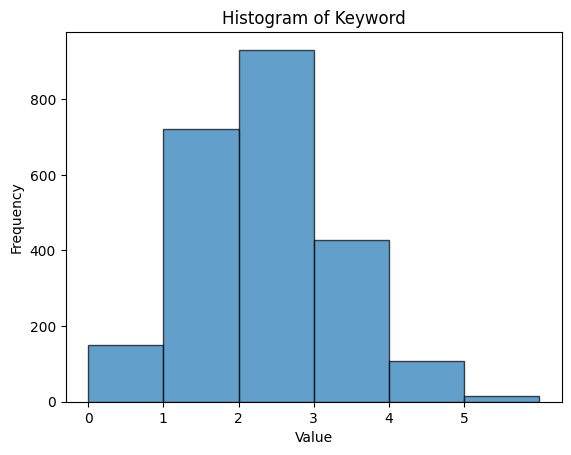

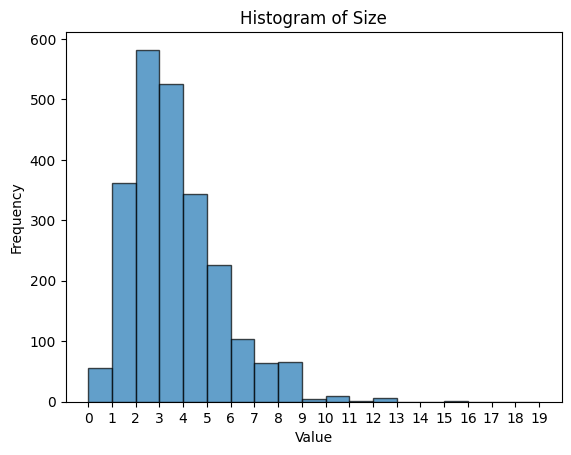

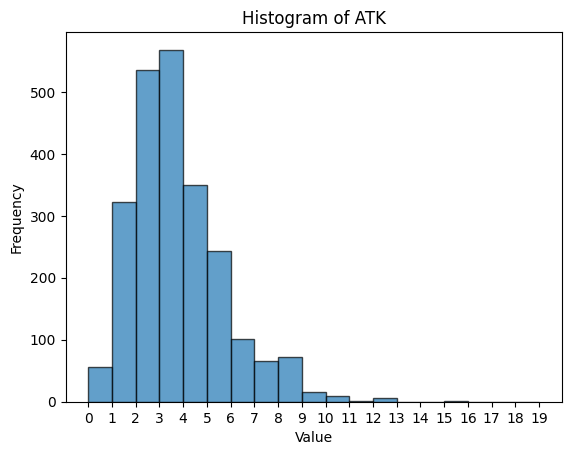

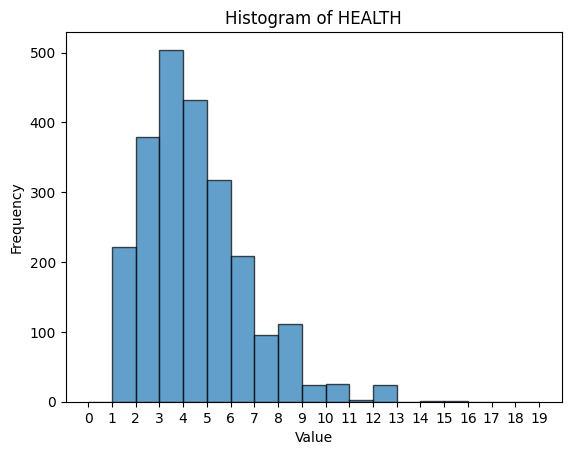

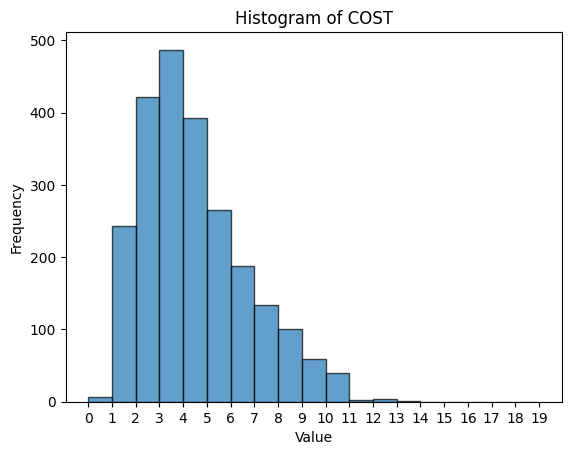

In [3]:
column_data = df['Keyword']
# 绘制直方图
plt.hist(column_data, bins=range(0,7), edgecolor='black', alpha=0.7)
plt.title("Histogram of Keyword")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.xticks(range(0,6))  # 设置X轴刻度为离散的整数值
plt.show()

column_data = df['Size']

# 绘制直方图
plt.hist(column_data, bins=range(0,20), edgecolor='black', alpha=0.7)
plt.title("Histogram of Size")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.xticks(range(0,20))
plt.show()

column_data = df['ATK']

# 绘制直方图
plt.hist(column_data, bins=range(0,20), edgecolor='black', alpha=0.7)
plt.title("Histogram of ATK")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.xticks(range(0,20))
plt.show()

column_data = df['HEALTH']

# 绘制直方图
plt.hist(column_data, bins=range(0,20), edgecolor='black', alpha=0.7)
plt.title("Histogram of HEALTH")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.xticks(range(0,20))
plt.show()

column_data = df['COST']

# 绘制直方图
plt.hist(column_data, bins=range(0,20), edgecolor='black', alpha=0.7)
plt.title("Histogram of COST")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.xticks(range(0,20))
plt.show()

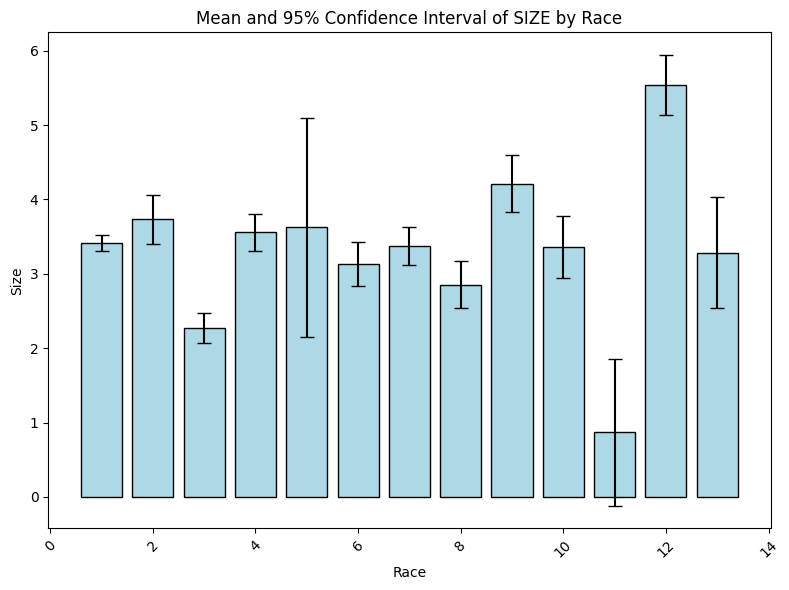

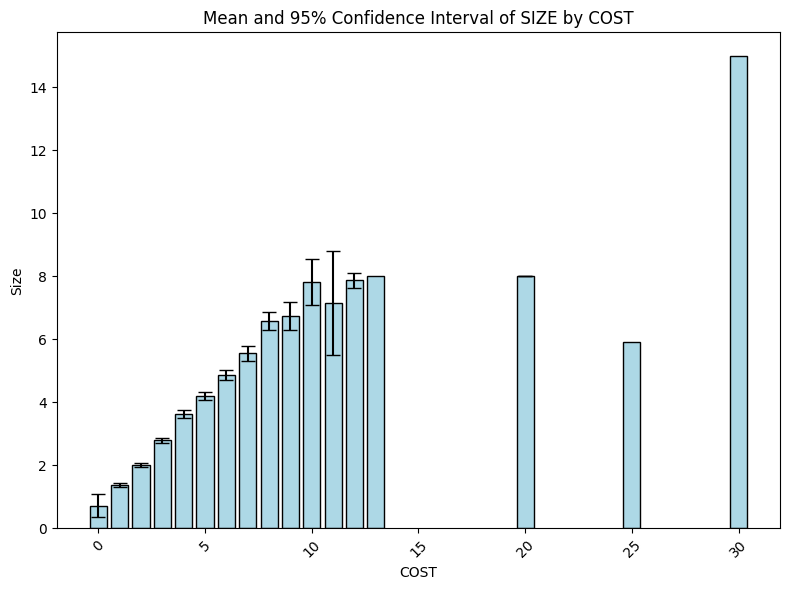

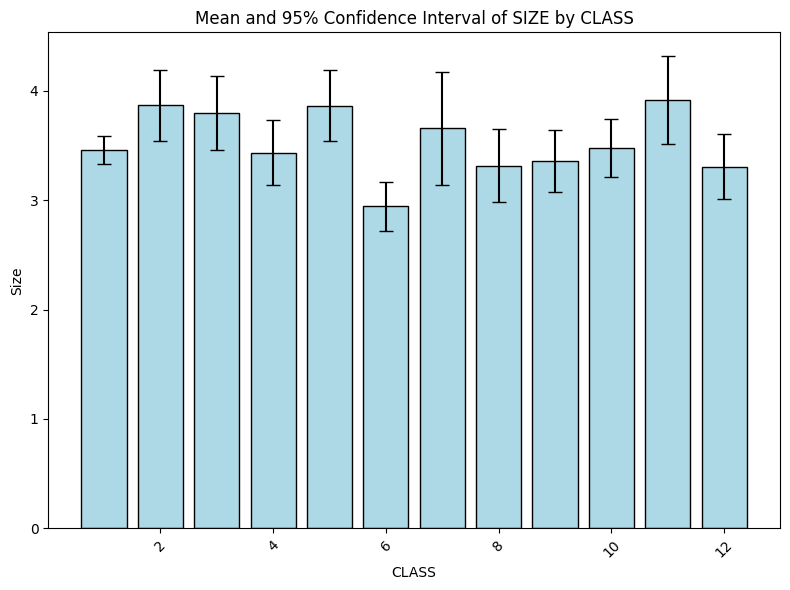

In [4]:
# 按 'RACE' 列分组，计算每组的 'SIZE' 列的均值、标准差和样本数量
grouped = df.groupby('RACE')['Size'].agg(['mean', 'std', 'count']).reset_index()

# 计算标准误差（Standard Error of the Mean, SEM）
grouped['sem'] = grouped['std'] / np.sqrt(grouped['count'])

# 计算置信区间 (95% 置信区间)
confidence_level = 0.95
z_score = stats.norm.ppf(1 - (1 - confidence_level) / 2)  # 对应95%置信区间的z值

# 计算置信区间的误差范围
grouped['ci_lower'] = grouped['mean'] - z_score * grouped['sem']
grouped['ci_upper'] = grouped['mean'] + z_score * grouped['sem']

# 绘制均值和置信区间
fig, ax = plt.subplots(figsize=(8, 6))

# 绘制均值的条形图
ax.bar(grouped['RACE'], grouped['mean'], yerr=[grouped['mean'] - grouped['ci_lower'], grouped['ci_upper'] - grouped['mean']], 
       capsize=5, color='lightblue', edgecolor='black', label='Mean with CI')

# 设置标签和标题
ax.set_xlabel('Race')
ax.set_ylabel('Size')
ax.set_title('Mean and 95% Confidence Interval of SIZE by Race')
plt.xticks(rotation=45)
plt.tight_layout()

# 显示图形
plt.show()

# 按 'COST' 列分组，计算每组的 'COST' 列的均值、标准差和样本数量
grouped = df.groupby('COST')['Size'].agg(['mean', 'std', 'count']).reset_index()

# 计算标准误差（Standard Error of the Mean, SEM）
grouped['sem'] = grouped['std'] / np.sqrt(grouped['count'])

# 计算置信区间的误差范围
grouped['ci_lower'] = grouped['mean'] - z_score * grouped['sem']
grouped['ci_upper'] = grouped['mean'] + z_score * grouped['sem']

# 绘制均值和置信区间
fig, ax = plt.subplots(figsize=(8, 6))

# 绘制均值的条形图
ax.bar(grouped['COST'], grouped['mean'], yerr=[grouped['mean'] - grouped['ci_lower'], grouped['ci_upper'] - grouped['mean']], 
       capsize=5, color='lightblue', edgecolor='black', label='Mean with CI')

# 设置标签和标题
ax.set_xlabel('COST')
ax.set_ylabel('Size')
ax.set_title('Mean and 95% Confidence Interval of SIZE by COST')
plt.xticks(rotation=45)
plt.tight_layout()

# 显示图形
plt.show()

# 按 'CLASS' 列分组，计算每组的 'CLASS' 列的均值、标准差和样本数量
grouped = df.groupby('CLASS')['Size'].agg(['mean', 'std', 'count']).reset_index()

# 计算标准误差（Standard Error of the Mean, SEM）
grouped['sem'] = grouped['std'] / np.sqrt(grouped['count'])

# 计算置信区间的误差范围
grouped['ci_lower'] = grouped['mean'] - z_score * grouped['sem']
grouped['ci_upper'] = grouped['mean'] + z_score * grouped['sem']

# 绘制均值和置信区间
fig, ax = plt.subplots(figsize=(8, 6))

# 绘制均值的条形图
ax.bar(grouped['CLASS'], grouped['mean'], yerr=[grouped['mean'] - grouped['ci_lower'], grouped['ci_upper'] - grouped['mean']], 
       capsize=5, color='lightblue', edgecolor='black', label='Mean with CI')

# 设置标签和标题
ax.set_xlabel('CLASS')
ax.set_ylabel('Size')
ax.set_title('Mean and 95% Confidence Interval of SIZE by CLASS')
plt.xticks(rotation=45)
plt.tight_layout()

# 显示图形
plt.show()

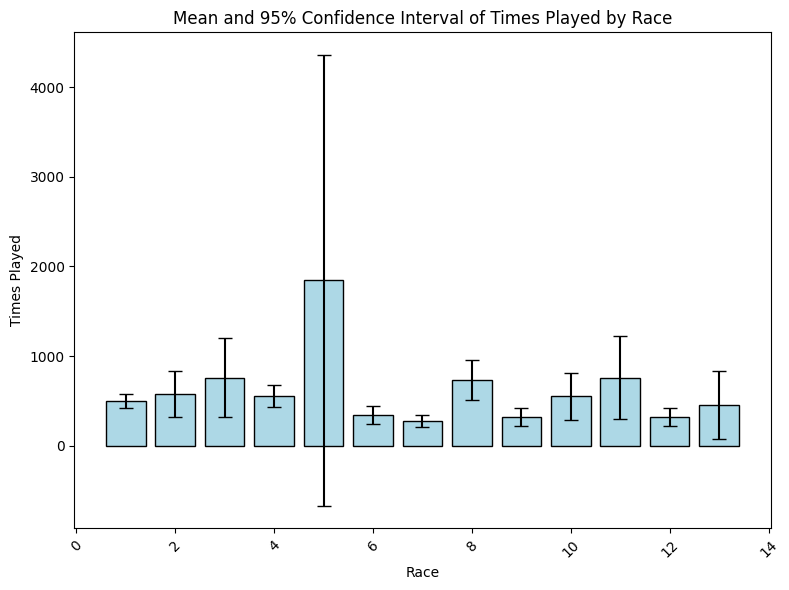

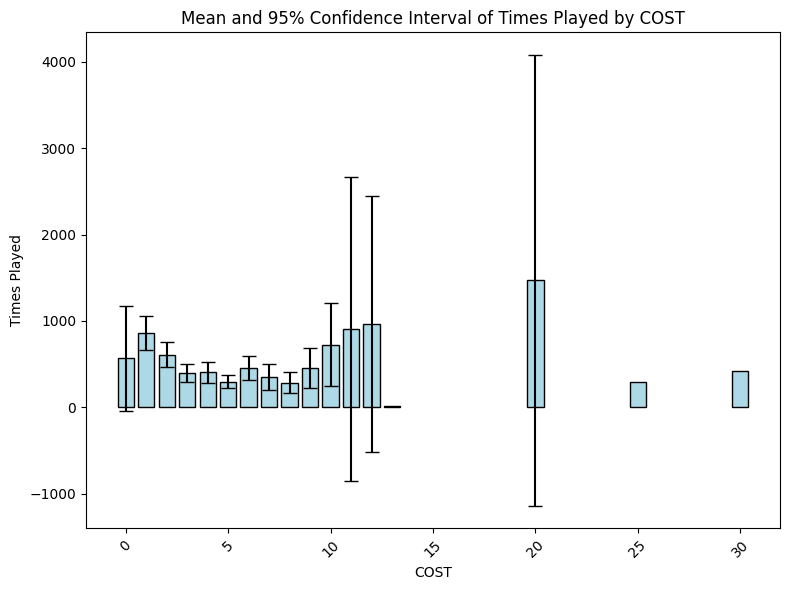

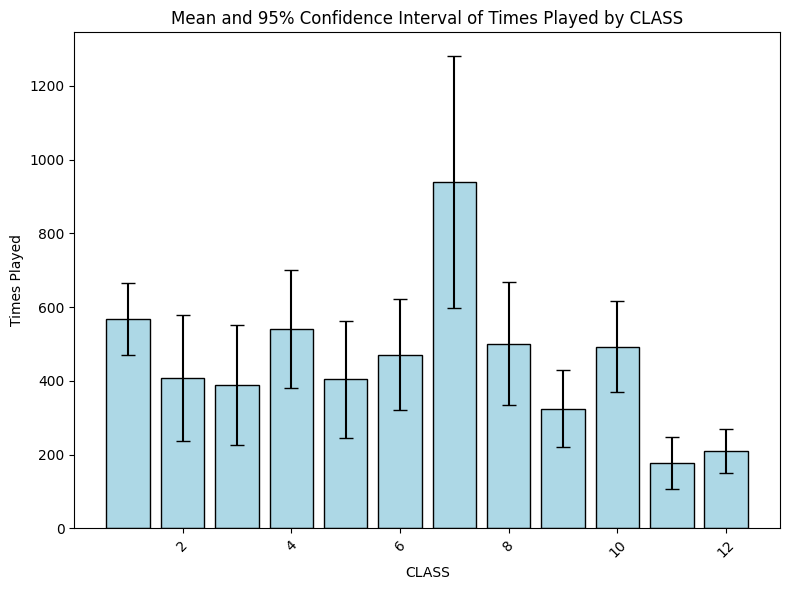

In [5]:
# 按 'RACE' 列分组，计算每组的 'times_played' 列的均值、标准差和样本数量
grouped = df.groupby('RACE')['times_played'].agg(['mean', 'std', 'count']).reset_index()

# 计算标准误差（Standard Error of the Mean, SEM）
grouped['sem'] = grouped['std'] / np.sqrt(grouped['count'])

# 计算置信区间 (95% 置信区间)
confidence_level = 0.95
z_score = stats.norm.ppf(1 - (1 - confidence_level) / 2)  # 对应95%置信区间的z值

# 计算置信区间的误差范围
grouped['ci_lower'] = grouped['mean'] - z_score * grouped['sem']
grouped['ci_upper'] = grouped['mean'] + z_score * grouped['sem']

# 绘制均值和置信区间
fig, ax = plt.subplots(figsize=(8, 6))

# 绘制均值的条形图
ax.bar(grouped['RACE'], grouped['mean'], yerr=[grouped['mean'] - grouped['ci_lower'], grouped['ci_upper'] - grouped['mean']], 
       capsize=5, color='lightblue', edgecolor='black', label='Mean with CI')

# 设置标签和标题
ax.set_xlabel('Race')
ax.set_ylabel('Times Played')
ax.set_title('Mean and 95% Confidence Interval of Times Played by Race')
plt.xticks(rotation=45)
plt.tight_layout()

# 显示图形
plt.show()

# 按 'COST' 列分组，计算每组的 'times_played' 列的均值、标准差和样本数量
grouped = df.groupby('COST')['times_played'].agg(['mean', 'std', 'count']).reset_index()

# 计算标准误差（Standard Error of the Mean, SEM）
grouped['sem'] = grouped['std'] / np.sqrt(grouped['count'])

# 计算置信区间的误差范围
grouped['ci_lower'] = grouped['mean'] - z_score * grouped['sem']
grouped['ci_upper'] = grouped['mean'] + z_score * grouped['sem']

# 绘制均值和置信区间
fig, ax = plt.subplots(figsize=(8, 6))

# 绘制均值的条形图
ax.bar(grouped['COST'], grouped['mean'], yerr=[grouped['mean'] - grouped['ci_lower'], grouped['ci_upper'] - grouped['mean']], 
       capsize=5, color='lightblue', edgecolor='black', label='Mean with CI')

# 设置标签和标题
ax.set_xlabel('COST')
ax.set_ylabel('Times Played')
ax.set_title('Mean and 95% Confidence Interval of Times Played by COST')
plt.xticks(rotation=45)
plt.tight_layout()

# 显示图形
plt.show()

# 按 'CLASS' 列分组，计算每组的 'times_played' 列的均值、标准差和样本数量
grouped = df.groupby('CLASS')['times_played'].agg(['mean', 'std', 'count']).reset_index()

# 计算标准误差（Standard Error of the Mean, SEM）
grouped['sem'] = grouped['std'] / np.sqrt(grouped['count'])

# 计算置信区间的误差范围
grouped['ci_lower'] = grouped['mean'] - z_score * grouped['sem']
grouped['ci_upper'] = grouped['mean'] + z_score * grouped['sem']

# 绘制均值和置信区间
fig, ax = plt.subplots(figsize=(8, 6))

# 绘制均值的条形图
ax.bar(grouped['CLASS'], grouped['mean'], yerr=[grouped['mean'] - grouped['ci_lower'], grouped['ci_upper'] - grouped['mean']], 
       capsize=5, color='lightblue', edgecolor='black', label='Mean with CI')

# 设置标签和标题
ax.set_xlabel('CLASS')
ax.set_ylabel('Times Played')
ax.set_title('Mean and 95% Confidence Interval of Times Played by CLASS')
plt.xticks(rotation=45)
plt.tight_layout()

# 显示图形
plt.show()


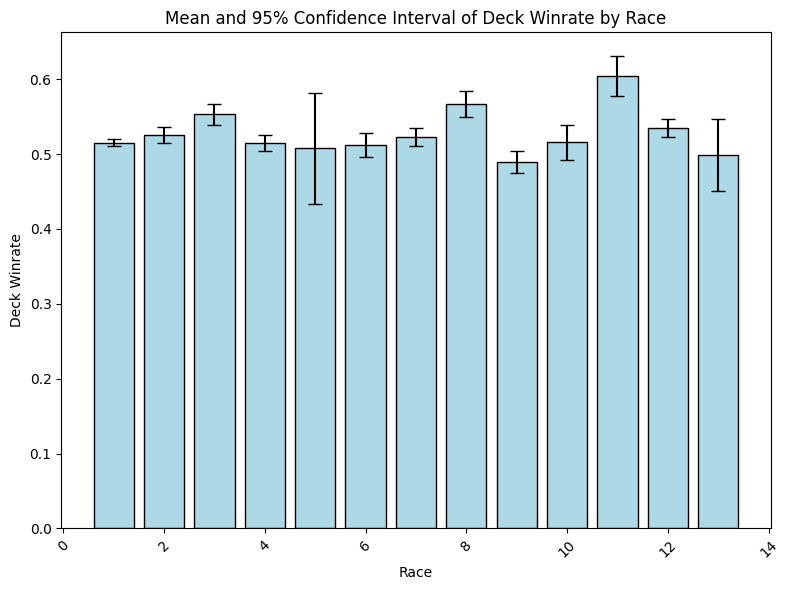

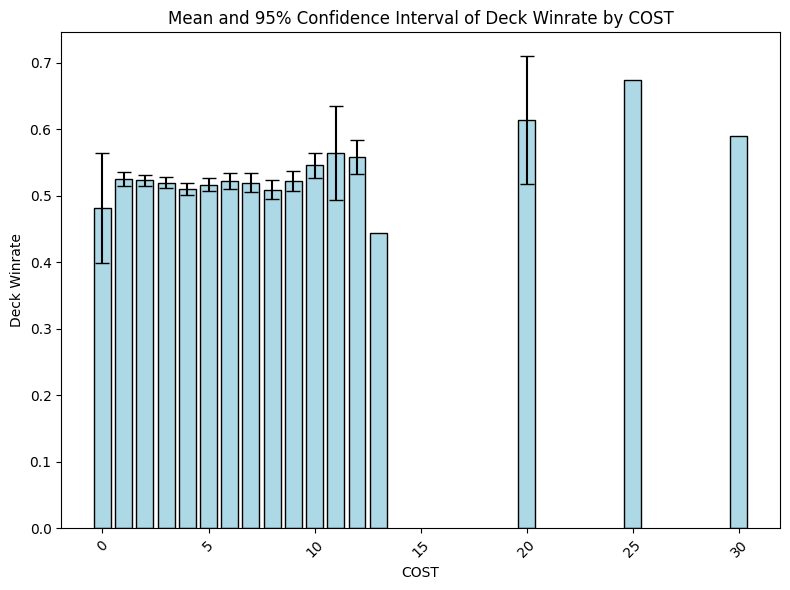

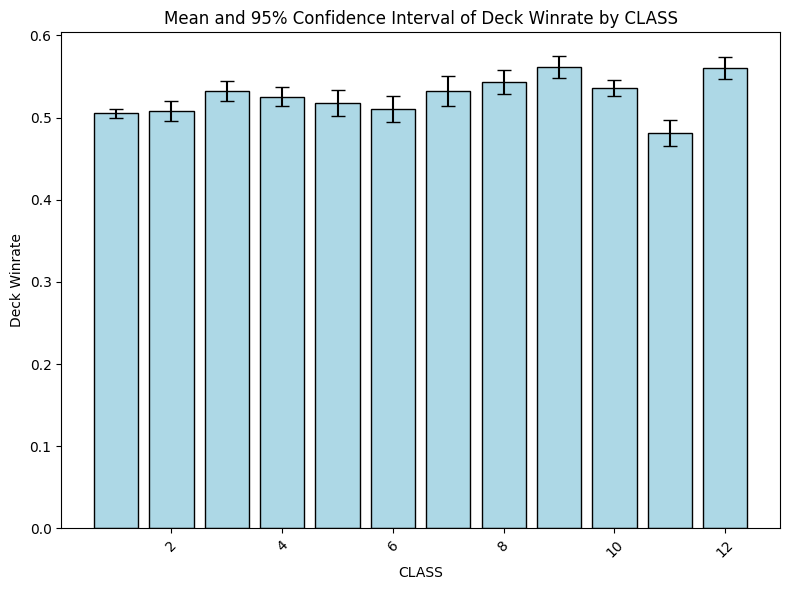

In [6]:
# 按 'RACE' 列分组，计算每组的 'deck_winrate' 列的均值、标准差和样本数量
grouped = df.groupby('RACE')['deck_winrate'].agg(['mean', 'std', 'count']).reset_index()

# 计算标准误差（Standard Error of the Mean, SEM）
grouped['sem'] = grouped['std'] / np.sqrt(grouped['count'])

# 计算置信区间的误差范围
grouped['ci_lower'] = grouped['mean'] - z_score * grouped['sem']
grouped['ci_upper'] = grouped['mean'] + z_score * grouped['sem']

# 绘制均值和置信区间
fig, ax = plt.subplots(figsize=(8, 6))

# 绘制均值的条形图
ax.bar(grouped['RACE'], grouped['mean'], yerr=[grouped['mean'] - grouped['ci_lower'], grouped['ci_upper'] - grouped['mean']], 
       capsize=5, color='lightblue', edgecolor='black', label='Mean with CI')

# 设置标签和标题
ax.set_xlabel('Race')
ax.set_ylabel('Deck Winrate')
ax.set_title('Mean and 95% Confidence Interval of Deck Winrate by Race')
plt.xticks(rotation=45)
plt.tight_layout()

# 显示图形
plt.show()

# 按 'COST' 列分组，计算每组的 'deck_winrate' 列的均值、标准差和样本数量
grouped = df.groupby('COST')['deck_winrate'].agg(['mean', 'std', 'count']).reset_index()

# 计算标准误差（Standard Error of the Mean, SEM）
grouped['sem'] = grouped['std'] / np.sqrt(grouped['count'])

# 计算置信区间的误差范围
grouped['ci_lower'] = grouped['mean'] - z_score * grouped['sem']
grouped['ci_upper'] = grouped['mean'] + z_score * grouped['sem']

# 绘制均值和置信区间
fig, ax = plt.subplots(figsize=(8, 6))

# 绘制均值的条形图
ax.bar(grouped['COST'], grouped['mean'], yerr=[grouped['mean'] - grouped['ci_lower'], grouped['ci_upper'] - grouped['mean']], 
       capsize=5, color='lightblue', edgecolor='black', label='Mean with CI')

# 设置标签和标题
ax.set_xlabel('COST')
ax.set_ylabel('Deck Winrate')
ax.set_title('Mean and 95% Confidence Interval of Deck Winrate by COST')
plt.xticks(rotation=45)
plt.tight_layout()

# 显示图形
plt.show()

# 按 'CLASS' 列分组，计算每组的 'deck_winrate' 列的均值、标准差和样本数量
grouped = df.groupby('CLASS')['deck_winrate'].agg(['mean', 'std', 'count']).reset_index()

# 计算标准误差（Standard Error of the Mean, SEM）
grouped['sem'] = grouped['std'] / np.sqrt(grouped['count'])

# 计算置信区间的误差范围
grouped['ci_lower'] = grouped['mean'] - z_score * grouped['sem']
grouped['ci_upper'] = grouped['mean'] + z_score * grouped['sem']

# 绘制均值和置信区间
fig, ax = plt.subplots(figsize=(8, 6))

# 绘制均值的条形图
ax.bar(grouped['CLASS'], grouped['mean'], yerr=[grouped['mean'] - grouped['ci_lower'], grouped['ci_upper'] - grouped['mean']], 
       capsize=5, color='lightblue', edgecolor='black', label='Mean with CI')

# 设置标签和标题
ax.set_xlabel('CLASS')
ax.set_ylabel('Deck Winrate')
ax.set_title('Mean and 95% Confidence Interval of Deck Winrate by CLASS')
plt.xticks(rotation=45)
plt.tight_layout()

# 显示图形
plt.show()


In [7]:
print(df.columns.tolist())

correlation_results = []
classes = df['CLASS'].unique()
for cls in classes:
    subset = df[df['CLASS'] == cls]
    if len(subset) > 1:  # 确保有足够数据计算相关性
        corr = subset[['Inflation', 'times_played']].corr().iloc[0, 1]
        correlation_results.append({'CLASS': cls, 'Correlation': corr})

# 转换为 DataFrame 并打印
correlation_df = pd.DataFrame(correlation_results)
print(correlation_df)


['card_name', 'in_perc_of_decks', 'avg_copies', 'deck_winrate', 'times_played', 'CLASS', 'RARITY', 'COST', 'HEALTH', 'ATK', 'BATTLECRY', 'DISCOVER', 'MANATHIRST', 'CARDRACE', 'TAUNT', 'TITAN', 'AURA', 'DEATHRATTLE', 'FREEZE', 'FORGE', 'DIVINE_SHIELD', 'CHARGE', 'HAS_SIGNATURE_QUALITY', 'MULTI_CLASS_GROUP', 'COMBO', 'CANT_BE_DAMAGED', 'OVERLOAD', 'REBORN', 'RUSH', 'DREDGE', 'SPELLPOWER', 'CORPSE', 'SECRET', 'MAGNETIC', 'WINDFURY', 'OUTCAST', 'POISONOUS', 'IMP', 'FINALE', 'LIFESTEAL', 'JADE_GOLEM', 'CHOOSE_ONE', 'INFUSE', 'COLOSSAL', 'START_OF_GAME', 'STEALTH', 'TRADEABLE', 'SILENCE', 'FRENZY', 'EMPOWER', 'SPELLBURST', 'CORRUPT', 'RITUAL', 'EVILZUG', 'DORMANT', 'ADAPT', 'DISCARD_CARDS', 'INSPIRE', 'ECHO', 'HONORABLEKILL', 'ENRAGED', 'RECRUIT', 'OVERHEAL', 'RACE', 'Keyword', 'Size', 'SizeTrue', 'Inflation']
    CLASS  Correlation
0       1     0.132359
1       2     0.125919
2       3    -0.058658
3       4     0.069019
4       5     0.130891
5       6     0.268387
6       7     0.157351


# Steps:
1. Split Dataset into CLASSes
2. Multivariate Regression
3. Train and Estimate
  
# Settings:
* Y: Popularity & Winning_rate
* X: Size, Cost, Keywords, (COMBO?)